<a href="https://colab.research.google.com/github/cda79/IAT360-LLM/blob/Thomas-Local-testing/IAT360_LLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Required libraries

In [ ]:
!pip install transformers torch datasets

In [ ]:
!pip install transformers torch accelerate

##Data Pre-processing
Convert CSV to huggingface & gpt-2 format

**Import raw .csv data**

In [25]:
import pandas as pd
from datasets import Dataset

df = pd.read_csv("Documents/GitHub/IAT360-LLM/shakespeare_dataset.csv")

# display it just to test
print(df.head())
df.info()

                                         shakespeare  \
0         To be, or not to be: that is the question.   
1            Shall I compare thee to a summer's day?   
2                         Wherefore art thou, Romeo?   
3             If music be the food of love, play on.   
4  Some are born great, some achieve greatness, a...   

                                              modern  
0        Should I live or die — that's the question.  
1              Should I compare you to a summer day?  
2                                 Why are you Romeo?  
3                 If music feeds love, keep playing.  
4  Some people are born great, some become great,...  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   shakespeare  5 non-null      object
 1   modern       5 non-null      object
dtypes: object(2)
memory usage: 212.0+ bytes


**Format it for gpt-2**

SOURCE: [Source Text] TARGET: [Target Text] <|endoftext|>

The <|endoftext|> token is for GPT-2 to signal the end of a generated sequence.


In [26]:
def format_translation_data(row):
  # whitespace cleanup
  shakespeare_text = row['shakespeare'].strip()
  modern_text = row['modern'].strip()
  formatted_text = f"SOURCE: {shakespeare_text} TARGET: {modern_text} <|endoftext|>"
  return formatted_text

# create new column for collated data to be tokenized
df['text_for_tokenization'] = df.apply(format_translation_data, axis=1)
# display it & check
print(df[['text_for_tokenization']].head())


                               text_for_tokenization
0  SOURCE: To be, or not to be: that is the quest...
1  SOURCE: Shall I compare thee to a summer's day...
2  SOURCE: Wherefore art thou, Romeo? TARGET: Why...
3  SOURCE: If music be the food of love, play on....
4  SOURCE: Some are born great, some achieve grea...


Full display of the text for double checking since the previous output cuts it out

In [27]:
import pandas as pd
pd.set_option('display.max_colwidth', None)

print(df[['text_for_tokenization']].to_string())

                                                                                                                                                                                          text_for_tokenization
0                                                                                          SOURCE: To be, or not to be: that is the question. TARGET: Should I live or die — that's the question. <|endoftext|>
1                                                                                                   SOURCE: Shall I compare thee to a summer's day? TARGET: Should I compare you to a summer day? <|endoftext|>
2                                                                                                                                   SOURCE: Wherefore art thou, Romeo? TARGET: Why are you Romeo? <|endoftext|>
3                                                                                                       SOURCE: If music be the food of love, play on. TARGET: If music 

**Format for the Huggingface trainer**

In [28]:
hf_dataset = Dataset.from_pandas(df)
print("\nConverted to Hugging Face Dataset format.")
print(hf_dataset)


Converted to Hugging Face Dataset format.
Dataset({
    features: ['shakespeare', 'modern', 'text_for_tokenization'],
    num_rows: 5
})


## Tokenization

**Define the tokenizer & apply**

Default gpt-2 padding & parameters.

To understand how gpt-2 tokenizes the text, [see here.](https://blog.lukesalamone.com/posts/gpt2-tokenization/)

In [29]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel, DataCollatorForLanguageModeling

# gpt-2 tokenizer to make it machine readable
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
# default padding token
tokenizer.pad_token = tokenizer.eos_token

# use the huggingface dataset we just converted
# hf_dataset = Dataset.from_pandas(df) << this was done in the previous step

def tokenize_function(examples):
    # uses the prepared 'text_for_tokenization' column
    return tokenizer(
        examples["text_for_tokenization"],
        truncation=True,
        max_length=256,
        padding="max_length"
    )

# apply tokenization
# done by mapping it to the dataset and then removing the columns without tokens
tokenized_datasets = hf_dataset.map(tokenize_function, batched=True, remove_columns=['shakespeare', 'modern', 'text_for_tokenization'])

# Display example tokenized output with the first entry
print("\n dataset structure:")
print(tokenized_datasets)
# where the input is decomposed into a string of numbers or tokens - depending on gpt-2s vocabulary
print(tokenized_datasets[0]["input_ids"])



Map: 100%|███████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 991.05 examples/s]


 dataset structure:
Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 5
})
[47690, 25, 1675, 307, 11, 393, 407, 284, 307, 25, 326, 318, 262, 1808, 13, 309, 46095, 25, 10358, 314, 2107, 393, 4656, 851, 326, 338, 262, 1808, 13, 220, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256

## Training

In [30]:
train_dataset = tokenized_datasets

# since we only have a test csv i just made it train on all the data
# otherwise we'd split it like this

#tokenized_datasets = tokenized_datasets.train_test_split(test_size=0.1)
# or for 80/20 split, where seed is the randomizer
# ... = tokenized_datasets.train_test_split(train_size=0.8, seed=40)

**Load the model and adjust the parameters**

Loading and deploying the gpt-2 model based off tokenized data: https://medium.com/@majd.farah08/generating-text-with-gpt2-in-under-10-lines-of-code-5725a38ea685

Documentation for data collating: https://huggingface.co/docs/transformers/main/main_classes/data_collator

... and what it does internally / the different types: https://towardsdatascience.com/data-collators-in-huggingface-a0c76db798d2/

In [32]:
from transformers import TrainingArguments, Trainer
import torch

# load gpt-2 model
model = GPT2LMHeadModel.from_pretrained("gpt2")

# data collating allows us to use our csv datatables as the input for model
# the mlm specifies whether we should mask tokens or not - usually used for prediction
# when its set to false then the labels = inputs with the padding ignored
# so the whole thing is read AND it returns the labels which is important for our specific translation use
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

# set up the trainer and its arguements
training_args = TrainingArguments(
    output_dir="./gpt2_shakespeare_translator",  # directory to save checkpoints
    num_train_epochs=50,                       # epoch size
    per_device_train_batch_size=4,             # batch size
    logging_steps=10,                          # log the stats of the training every 10 steps, creates a consistent loss chart
)

# initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    data_collator=data_collator,
)

trainer.train()


C:\Users\Thomas\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
10,2.566400
20,1.004000
30,0.361900
40,0.214500
50,0.141800
60,0.083400
70,0.140300
80,0.107600
90,0.176000
100,0.105900


TrainOutput(global_step=100, training_loss=0.49019491851329805, metrics={'train_runtime': 215.4249, 'train_samples_per_second': 1.16, 'train_steps_per_second': 0.464, 'total_flos': 32661504000000.0, 'train_loss': 0.49019491851329805, 'epoch': 50.0})

## Generate loss function graph

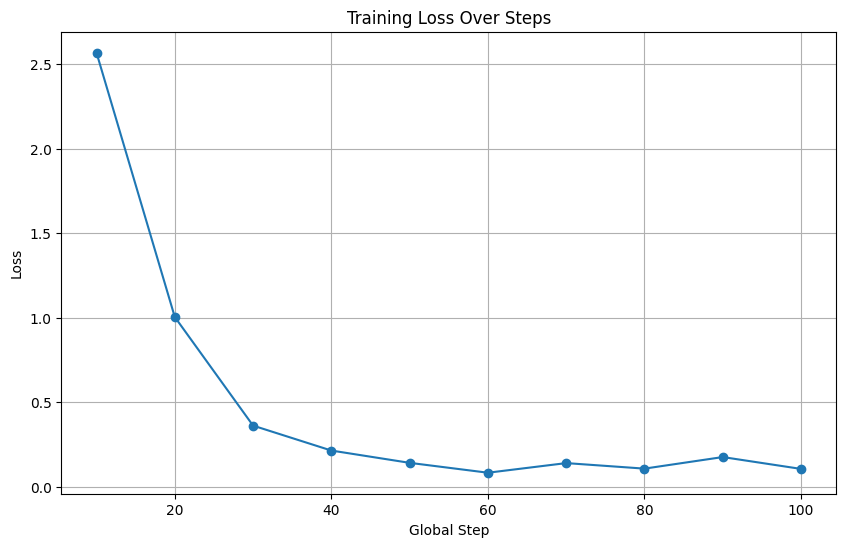

In [34]:
import matplotlib.pyplot as plt

if 'trainer' in locals() or 'trainer' in globals():
    log_history = trainer.state.log_history

    steps = []
    losses = []

    for entry in log_history:
        if 'loss' in entry and 'step' in entry: # Filter for step-wise logs
            steps.append(entry['step'])
            losses.append(entry['loss'])

    if steps and losses:
        plt.figure(figsize=(10, 6))
        plt.plot(steps, losses, marker='o', linestyle='-')
        plt.title('Training Loss Over Steps')
        plt.xlabel('Global Step')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.show()
    else:
        # If no step-wise loss was found, check for the final aggregated training_loss
        final_train_loss_entry = None
        for entry in log_history:
            if 'train_loss' in entry:
                final_train_loss_entry = entry
                break

        if final_train_loss_entry:
            print(f"Only the final training loss is available: {final_train_loss_entry['train_loss']} at step {final_train_loss_entry['step']}.")
            print("A graph requires multiple data points. To see loss progression, ensure 'logging_steps' is set appropriately in TrainingArguments and logs are accessible.")
            # Optionally, plot a single point if that's all there is
            plt.figure(figsize=(2, 2))
            plt.plot([final_train_loss_entry['step']], [final_train_loss_entry['train_loss']], marker='X', color='red', markersize=10)
            plt.title('Final Training Loss')
            plt.xlabel('Global Step')
            plt.ylabel('Loss')
            plt.grid(True)
            plt.show()
        else:
            print("No training loss data found.")
else:
    print("The 'trainer' object was not found.")


##Ignore this code - for pre-made datasets

###Import pre-made dataset

In [ ]:
from datasets import load_dataset
dataset = load_dataset("lanretto/shakespeare-vs-modern-dialogue")
dataset

In [ ]:
## For now, unused
# from datasets import load_dataset
# dataset = load_dataset("madha98/Shakespeare")
# dataset

###Data pre-processing - for training/test split

In [ ]:
#example print
dataset['train'][0]

In [ ]:
#shuffle and split the dataset into a smaller amount
#select only the first 100 and shuffle them up
dataset = dataset['train'].shuffle(seed=30).select(range(100))
dataset

In [ ]:
# create test and train dataset from this shuffled amount
# 80-20 split
dataset = dataset.train_test_split(train_size=0.8, seed=40)
dataset


### Load custom dataset files
For when we make our own, here is some temp code (not to be run)

In [ ]:
#Load files as dataset
data_files={"train": "train.csv", "test": "test.csv"}
dataset = load_dataset("csv", data_files=data_files)
dataset

Save it to our huggingface hub (not to be run)

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

###Tokenization

So this is when we'd split our custom dataset into a third column that combines the features together into one line for training i think